In [1]:
#Import Dependencies
import tensorflow as tf
import os
import cv2
import imghdr
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
!python --version

Python 3.10.13


In [4]:
tf.__version__

'2.10.1'

In [10]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
#Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# Verifying correct data separation
print(os.listdir('chest_xray/train'))
os.listdir('chest_xray/test')

['NORMAL', 'PNEUMONIA']


['NORMAL', 'PNEUMONIA']

In [4]:
# Checking image size
img = cv2.imread(os.path.join('chest_xray', 'train', 'NORMAL', 'NORMAL-28501-0001.jpeg'))
img.shape

(2418, 2434, 3)

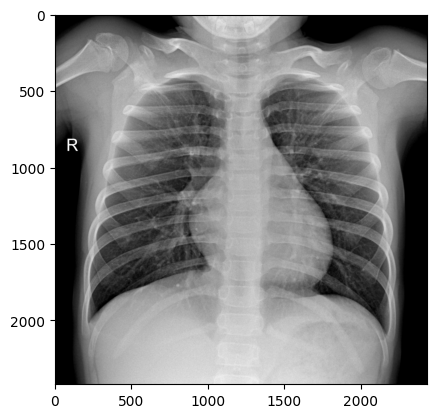

In [5]:
# Example image
plt.imshow(img)

In [6]:
test_data = tf.keras.utils.image_dataset_from_directory('chest_xray/test', batch_size=32)
train_data = tf.keras.utils.image_dataset_from_directory('chest_xray/train', batch_size=32)

Found 624 files belonging to 2 classes.
Found 5232 files belonging to 2 classes.


In [7]:
training_data_iterator = train_data.as_numpy_iterator()
testing_data_iterator = test_data.as_numpy_iterator()

In [8]:
# Getting a batch of data
train_batch = training_data_iterator.next()
test_batch = testing_data_iterator.next()
print(test_batch[0].shape)
train_batch[0].shape

(32, 256, 256, 3)


(32, 256, 256, 3)

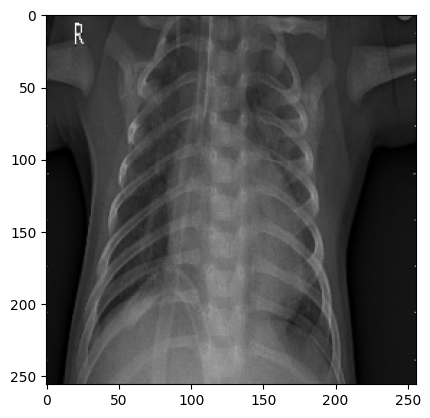

In [9]:
plt.imshow(test_batch[0][0].astype('int'))

In [10]:
# 1 = Pneumonia, 0 = Normal? (Will Double Check Later)
train_batch[1]

array([0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1])

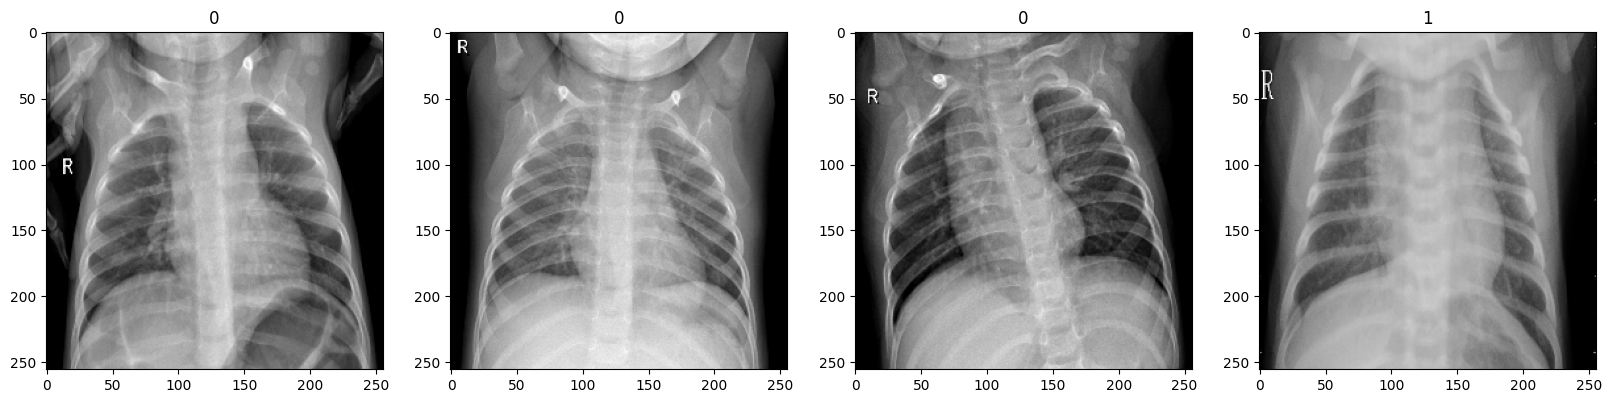

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(train_batch[0][:4]):
    ax[idx].imshow(img.astype('int'))
    ax[idx].set_title(train_batch[1][idx])

In [12]:
# Initial bounds
print(train_batch[0].min(), train_batch[0].max())
print(test_batch[0].min(), test_batch[0].max())

0.0 255.0
0.0 255.0


In [13]:
# Scaled data bounds
train_scaled = train_batch[0] / 255
test_scaled = test_batch[0] / 255

print(train_scaled.min(), train_scaled.max())
print(test_scaled.min(), test_scaled.max())

0.0 1.0
0.0 1.0


# PreProcessing

In [14]:
train_scaled_data = train_data.map(lambda x, y: (x/255, y))
test_scaled_data = test_data.map(lambda x, y: (x/255, y))

In [15]:
train_scaled_data.as_numpy_iterator().next()[0].max(), train_scaled_data.as_numpy_iterator().next()[0].min()
test_scaled_data.as_numpy_iterator().next()[0].max(), test_scaled_data.as_numpy_iterator().next()[0].min()

(1.0, 0.0)

In [16]:
print(len(train_scaled_data))
print(len(test_scaled_data))

164
20


# Building the Model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [19]:
model = Sequential()

In [20]:
# Add a 2D convolutional layer with 16 filters, a 3x3 kernel, Stride of 1, and ReLU activation
# Input shape is (256, 256, 3)
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))

# Add a max pooling layer
model.add(MaxPooling2D())

# Add another 2D convolutional layer with 32 filters, a 3x3 kernel, and ReLU activation
model.add(Conv2D(32, (3,3), 1, activation='relu'))

# Add another max pooling layer
model.add(MaxPooling2D())

# Add another 2D convolutional layer with 16 filters, a 3x3 kernel, and ReLU activation
model.add(Conv2D(16, (3,3), 1, activation='relu'))

# Add another max pooling layer
model.add(MaxPooling2D())

# Flatten the output of the previous layer
model.add(Flatten())

# Add a fully connected layer with 256 units and ReLU activation
model.add(Dense(256, activation='relu'))

# Add a final fully connected layer with 1 unit and sigmoid activation
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [23]:
hist = model.fit(train_scaled_data, epochs=10)

Epoch 1/10
164/164 [==============================] - 10s 40ms/step - loss: 0.2469 - accuracy: 0.8945
Epoch 2/10
164/164 [==============================] - 7s 42ms/step - loss: 0.1098 - accuracy: 0.9568
Epoch 3/10
164/164 [==============================] - 7s 42ms/step - loss: 0.0851 - accuracy: 0.9683
Epoch 4/10
164/164 [==============================] - 8s 44ms/step - loss: 0.0626 - accuracy: 0.9778
Epoch 5/10
164/164 [==============================] - 7s 43ms/step - loss: 0.0538 - accuracy: 0.9790
Epoch 6/10
164/164 [==============================] - 8s 44ms/step - loss: 0.0424 - accuracy: 0.9845
Epoch 7/10
164/164 [==============================] - 8s 43ms/step - loss: 0.0282 - accuracy: 0.9889
Epoch 8/10
164/164 [==============================] - 7s 43ms/step - loss: 0.0247 - accuracy: 0.9906
Epoch 9/10
164/164 [==============================] - 8s 45ms/step - loss: 0.0126 - accuracy: 0.9954
Epoch 10/10
164/164 [==============================] - 8s 45ms/step - loss: 0.0262 - accur

In [24]:
hist.history

{'loss': [0.24688927829265594,
  0.10984355211257935,
  0.08509349822998047,
  0.06256948411464691,
  0.053815945982933044,
  0.04237117990851402,
  0.028247956186532974,
  0.0246947780251503,
  0.012561141513288021,
  0.02619738131761551],
 'accuracy': [0.89449542760849,
  0.9568042755126953,
  0.9682721495628357,
  0.9778287410736084,
  0.9789755344390869,
  0.9845183491706848,
  0.9889143705368042,
  0.990634560585022,
  0.9954128265380859,
  0.990634560585022]}

# Plotting

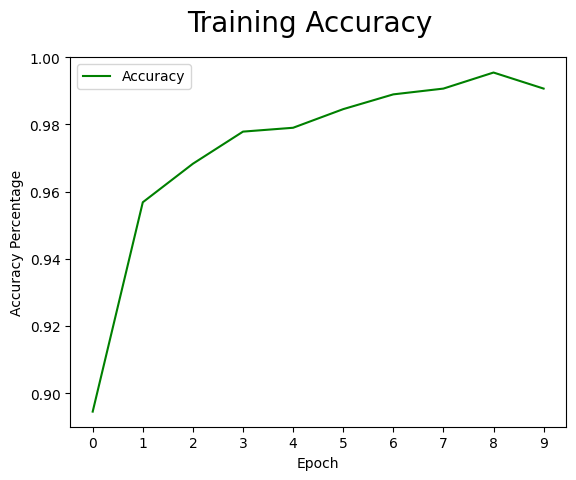

In [25]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='green', label='Accuracy')
fig.suptitle('Training Accuracy', fontsize=20)
plt.legend(loc='best')
plt.xticks(range(0,10))
plt.ylim(0.89,1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy Percentage')
plt.show()

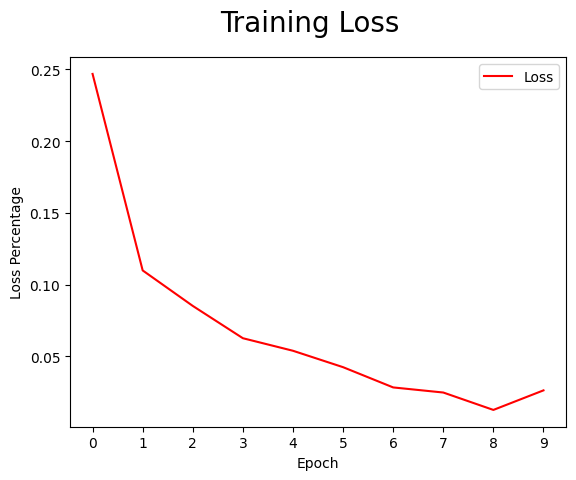

In [26]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='Loss')
fig.suptitle('Training Loss', fontsize=20)
plt.legend(loc='best')
plt.xticks(range(0,10))
plt.xlabel('Epoch')
plt.ylabel('Loss Percentage')
plt.show()

# Evaluation

In [27]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [28]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [29]:
len(test_scaled_data)

20

In [30]:
for batch in test_scaled_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 70ms/step


In [31]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.7848360538482666, Recall: 0.9820512533187866, Accuracy: 0.8205128312110901


# Test